# ERDDCI with Prompt-to-Prompt(Stable Diffusion)


In [1]:
from typing import Optional, Union, Tuple, List, Callable, Dict
import os, gc
import abc
import torch
from tqdm.notebook import tqdm
from diffusers import StableDiffusionPipeline, DDIMScheduler
import torch.nn.functional as nnf
import numpy as np
import pandas as pd
from PIL import Image
import lpips
from skimage.metrics import structural_similarity as SSIM
from skimage.metrics import peak_signal_noise_ratio as PSNR

import ptp_utils
import seq_aligner

For loading the Stable Diffusion using Diffusers, follow the instuctions https://huggingface.co/blog/stable_diffusion and update `MY_TOKEN` with your token.
Set `LOW_RESOURCE` to `True` for running on 12GB GPU.


In [2]:
# MY_TOKEN = ''
LOW_RESOURCE = False
NUM_DIFFUSION_STEPS = 50
GUIDANCE_SCALE = 10
MAX_NUM_WORDS = (
    77 * 1
)  # Because of the model structure, this must be set to （77 * integer)
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

In [3]:
gc.collect()
torch.cuda.empty_cache()

In [4]:
scheduler = DDIMScheduler(
    beta_start=0.00085,
    beta_end=0.012,
    beta_schedule="scaled_linear",
    clip_sample=False,
    set_alpha_to_one=False,
)
ldm_stable = StableDiffusionPipeline.from_pretrained(
    "CompVis/stable-diffusion-v1-4", local_files_only=True, scheduler=scheduler
).to(device)
try:
    ldm_stable.disable_xformers_memory_efficient_attention()
except AttributeError:
    print("Attribute disable_xformers_memory_efficient_attention() is missing")
tokenizer = ldm_stable.tokenizer

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

/home/djm/ERDDCI/.venv/lib/python3.11/site-packages/diffusers/pipelines/stable_diffusion/pipeline_stable_diffusion.py:223: FutureWarning: The configuration file of this scheduler: DDIMScheduler {
  "_class_name": "DDIMScheduler",
  "_diffusers_version": "0.33.1",
  "beta_end": 0.012,
  "beta_schedule": "scaled_linear",
  "beta_start": 0.00085,
  "clip_sample": false,
  "clip_sample_range": 1.0,
  "dynamic_thresholding_ratio": 0.995,
  "num_train_timesteps": 1000,
  "prediction_type": "epsilon",
  "rescale_betas_zero_snr": false,
  "sample_max_value": 1.0,
  "set_alpha_to_one": false,
  "steps_offset": 0,
  "thresholding": false,
  "timestep_spacing": "leading",
  "trained_betas": null
}
 is outdated. `steps_offset` should be set to 1 instead of 0. Please make sure to update the config accordingly as leaving `steps_offset` might led to incorrect results in future versions. If you have downloaded this checkpoint from the Hugging Face Hub, it would be very nice if you could open a Pull re

### Prompt-to-Prompt Attnetion Controllers

The warnings and errors in this P2P code section are non-critical - please proceed with execution.


In [5]:
class LocalBlend:
    def __call__(self, x_t, attention_store):
        k = 1
        maps = attention_store["down_cross"][2:4] + attention_store["up_cross"][:3]
        maps = [
            item.reshape(self.alpha_layers.shape[0], -1, 1, 16, 16, MAX_NUM_WORDS)
            for item in maps
        ]
        maps = torch.cat(maps, dim=1)
        maps = (maps * self.alpha_layers).sum(-1).mean(1)
        mask = nnf.max_pool2d(maps, (k * 2 + 1, k * 2 + 1), (1, 1), padding=(k, k))
        mask = nnf.interpolate(mask, size=(x_t.shape[2:]))
        mask = mask / mask.max(2, keepdims=True)[0].max(3, keepdims=True)[0]
        mask = mask.gt(self.threshold)
        mask = (mask[:1] + mask[1:]).float()
        x_t = x_t[:1] + mask * (x_t - x_t[:1])
        return x_t

    def __init__(self, prompts: List[str], words: [List[List[str]]], threshold=0.3):
        alpha_layers = torch.zeros(len(prompts), 1, 1, 1, 1, MAX_NUM_WORDS)
        for i, (prompt, words_) in enumerate(zip(prompts, words)):
            if type(words_) is str:
                words_ = [words_]
            for word in words_:
                ind = ptp_utils.get_word_inds(prompt, word, tokenizer)
                alpha_layers[i, :, :, :, :, ind] = 1
        self.alpha_layers = alpha_layers.to(device)
        self.threshold = threshold


class AttentionControl(abc.ABC):
    def step_callback(self, x_t):
        return x_t

    def between_steps(self):
        return

    @property
    def num_uncond_att_layers(self):
        return self.num_att_layers if LOW_RESOURCE else 0

    @abc.abstractmethod
    def forward(self, attn, is_cross: bool, place_in_unet: str):
        raise NotImplementedError

    def __call__(self, attn, is_cross: bool, place_in_unet: str):
        if self.cur_att_layer >= self.num_uncond_att_layers:
            if LOW_RESOURCE:
                attn = self.forward(attn, is_cross, place_in_unet)
            else:
                h = attn.shape[0]
                attn[h // 2 :] = self.forward(attn[h // 2 :], is_cross, place_in_unet)
        self.cur_att_layer += 1
        if self.cur_att_layer == self.num_att_layers + self.num_uncond_att_layers:
            self.cur_att_layer = 0
            self.cur_step += 1
            self.between_steps()
        return attn

    def reset(self):
        self.cur_step = 0
        self.cur_att_layer = 0

    def __init__(self):
        self.cur_step = 0
        self.num_att_layers = -1
        self.cur_att_layer = 0


class EmptyControl(AttentionControl):
    def forward(self, attn, is_cross: bool, place_in_unet: str):
        return attn


class AttentionStore(AttentionControl):
    @staticmethod
    def get_empty_store():
        return {
            "down_cross": [],
            "mid_cross": [],
            "up_cross": [],
            "down_self": [],
            "mid_self": [],
            "up_self": [],
        }

    def forward(self, attn, is_cross: bool, place_in_unet: str):
        key = f"{place_in_unet}_{'cross' if is_cross else 'self'}"
        if attn.shape[1] <= 32**2:  # avoid memory overhead
            self.step_store[key].append(attn)
        return attn

    def between_steps(self):
        if len(self.attention_store) == 0:
            self.attention_store = self.step_store
        else:
            for key in self.attention_store:
                for i in range(len(self.attention_store[key])):
                    self.attention_store[key][i] += self.step_store[key][i]
        self.step_store = self.get_empty_store()

    def get_average_attention(self):
        average_attention = {
            key: [item / self.cur_step for item in self.attention_store[key]]
            for key in self.attention_store
        }
        return average_attention

    def reset(self):
        super(AttentionStore, self).reset()
        self.step_store = self.get_empty_store()
        self.attention_store = {}

    def __init__(self):
        super(AttentionStore, self).__init__()
        self.step_store = self.get_empty_store()
        self.attention_store = {}


class AttentionControlEdit(AttentionStore, abc.ABC):
    def step_callback(self, x_t):
        if self.local_blend is not None:
            x_t = self.local_blend(x_t, self.attention_store)
        return x_t

    def replace_self_attention(self, attn_base, att_replace):
        if att_replace.shape[2] <= 16**2:
            return attn_base.unsqueeze(0).expand(att_replace.shape[0], *attn_base.shape)
        else:
            return att_replace

    @abc.abstractmethod
    def replace_cross_attention(self, attn_base, att_replace):
        raise NotImplementedError

    def forward(self, attn, is_cross: bool, place_in_unet: str):
        super(AttentionControlEdit, self).forward(attn, is_cross, place_in_unet)
        if is_cross or (
            self.num_self_replace[0] <= self.cur_step < self.num_self_replace[1]
        ):
            h = attn.shape[0] // (self.batch_size)
            attn = attn.reshape(self.batch_size, h, *attn.shape[1:])
            attn_base, attn_repalce = attn[0], attn[1:]
            if is_cross:
                alpha_words = self.cross_replace_alpha[self.cur_step]
                attn_repalce_new = (
                    self.replace_cross_attention(attn_base, attn_repalce) * alpha_words
                    + (1 - alpha_words) * attn_repalce
                )
                attn[1:] = attn_repalce_new
            else:
                attn[1:] = self.replace_self_attention(attn_base, attn_repalce)
            attn = attn.reshape(self.batch_size * h, *attn.shape[2:])
        return attn

    def __init__(
        self,
        prompts,
        num_steps: int,
        cross_replace_steps: Union[
            float, Tuple[float, float], Dict[str, Tuple[float, float]]
        ],
        self_replace_steps: Union[float, Tuple[float, float]],
        local_blend: Optional[LocalBlend],
    ):
        super(AttentionControlEdit, self).__init__()
        self.batch_size = len(prompts)
        self.cross_replace_alpha = ptp_utils.get_time_words_attention_alpha(
            prompts, num_steps, cross_replace_steps, tokenizer
        ).to(device)
        if type(self_replace_steps) is float:
            self_replace_steps = 0, self_replace_steps
        self.num_self_replace = (
            int(num_steps * self_replace_steps[0]),
            int(num_steps * self_replace_steps[1]),
        )
        self.local_blend = local_blend


class AttentionReplace(AttentionControlEdit):
    def replace_cross_attention(self, attn_base, att_replace):
        return torch.einsum("hpw,bwn->bhpn", attn_base, self.mapper)

    def __init__(
        self,
        prompts,
        num_steps: int,
        cross_replace_steps: float,
        self_replace_steps: float,
        local_blend: Optional[LocalBlend] = None,
    ):
        super(AttentionReplace, self).__init__(
            prompts, num_steps, cross_replace_steps, self_replace_steps, local_blend
        )
        self.mapper = seq_aligner.get_replacement_mapper(prompts, tokenizer).to(device)


class AttentionRefine(AttentionControlEdit):
    def replace_cross_attention(self, attn_base, att_replace):
        attn_base_replace = attn_base[:, :, self.mapper].permute(2, 0, 1, 3)
        attn_replace = attn_base_replace * self.alphas + att_replace * (1 - self.alphas)
        return attn_replace

    def __init__(
        self,
        prompts,
        num_steps: int,
        cross_replace_steps: float,
        self_replace_steps: float,
        local_blend: Optional[LocalBlend] = None,
    ):
        super(AttentionRefine, self).__init__(
            prompts, num_steps, cross_replace_steps, self_replace_steps, local_blend
        )
        self.mapper, alphas = seq_aligner.get_refinement_mapper(prompts, tokenizer)
        self.mapper, alphas = self.mapper.to(device), alphas.to(device)
        self.alphas = alphas.reshape(alphas.shape[0], 1, 1, alphas.shape[1])


class AttentionReweight(AttentionControlEdit):
    def replace_cross_attention(self, attn_base, att_replace):
        if self.prev_controller is not None:
            attn_base = self.prev_controller.replace_cross_attention(
                attn_base, att_replace
            )
        attn_replace = attn_base[None, :, :, :] * self.equalizer[:, None, None, :]
        return attn_replace

    def __init__(
        self,
        prompts,
        num_steps: int,
        cross_replace_steps: float,
        self_replace_steps: float,
        equalizer,
        local_blend: Optional[LocalBlend] = None,
        controller: Optional[AttentionControlEdit] = None,
    ):
        super(AttentionReweight, self).__init__(
            prompts, num_steps, cross_replace_steps, self_replace_steps, local_blend
        )
        self.equalizer = equalizer.to(device)
        self.prev_controller = controller


def get_equalizer(
    text: str,
    word_select: Union[int, Tuple[int, ...]],
    values: Union[List[float], Tuple[float, ...]],
):
    if type(word_select) is int or type(word_select) is str:
        word_select = (word_select,)
    equalizer = torch.ones(1, 77)

    for word, val in zip(word_select, values):
        inds = ptp_utils.get_word_inds(text, word, tokenizer)
        equalizer[:, inds] = val
    return equalizer


def aggregate_attention(
    attention_store: AttentionStore,
    res: int,
    from_where: List[str],
    is_cross: bool,
    select: int,
):
    out = []
    attention_maps = attention_store.get_average_attention()
    num_pixels = res**2
    for location in from_where:
        for item in attention_maps[f"{location}_{'cross' if is_cross else 'self'}"]:
            if item.shape[1] == num_pixels:
                cross_maps = item.reshape(len(prompts), -1, res, res, item.shape[-1])[
                    select
                ]
                out.append(cross_maps)
    out = torch.cat(out, dim=0)
    out = out.sum(0) / out.shape[0]
    return out.cpu()


def make_controller(
    prompts: List[str],
    is_replace_controller: bool,
    cross_replace_steps: Dict[str, float],
    self_replace_steps: float,
    blend_words=None,
    equilizer_params=None,
) -> AttentionControlEdit:
    if blend_words is None:
        lb = None
    else:
        lb = LocalBlend(prompts, blend_word)
    if is_replace_controller:
        controller = AttentionReplace(
            prompts,
            NUM_DIFFUSION_STEPS,
            cross_replace_steps=cross_replace_steps,
            self_replace_steps=self_replace_steps,
            local_blend=lb,
        )
    else:
        controller = AttentionRefine(
            prompts,
            NUM_DIFFUSION_STEPS,
            cross_replace_steps=cross_replace_steps,
            self_replace_steps=self_replace_steps,
            local_blend=lb,
        )
    if equilizer_params is not None:
        eq = get_equalizer(
            prompts[1], equilizer_params["words"], equilizer_params["values"]
        )
        controller = AttentionReweight(
            prompts,
            NUM_DIFFUSION_STEPS,
            cross_replace_steps=cross_replace_steps,
            self_replace_steps=self_replace_steps,
            equalizer=eq,
            local_blend=lb,
            controller=controller,
        )
    return controller


def show_cross_attention(
    attention_store: AttentionStore, res: int, from_where: List[str], select: int = 0
):
    tokens = tokenizer.encode(prompts[select])
    decoder = tokenizer.decode
    attention_maps = aggregate_attention(attention_store, res, from_where, True, select)
    images = []
    for i in range(len(tokens)):
        image = attention_maps[:, :, i]
        image = 255 * image / image.max()
        image = image.unsqueeze(-1).expand(*image.shape, 3)
        image = image.numpy().astype(np.uint8)
        image = np.array(Image.fromarray(image).resize((256, 256)))
        image = ptp_utils.text_under_image(image, decoder(int(tokens[i])))
        images.append(image)
    ptp_utils.view_images(np.stack(images, axis=0))


def show_self_attention_comp(
    attention_store: AttentionStore,
    res: int,
    from_where: List[str],
    max_com=10,
    select: int = 0,
):
    attention_maps = (
        aggregate_attention(attention_store, res, from_where, False, select)
        .numpy()
        .reshape((res**2, res**2))
    )
    u, s, vh = np.linalg.svd(
        attention_maps - np.mean(attention_maps, axis=1, keepdims=True)
    )
    images = []
    for i in range(max_com):
        image = vh[i].reshape(res, res)
        image = image - image.min()
        image = 255 * image / image.max()
        image = np.repeat(np.expand_dims(image, axis=2), 3, axis=2).astype(np.uint8)
        image = Image.fromarray(image).resize((256, 256))
        image = np.array(image)
        images.append(image)
    ptp_utils.view_images(np.concatenate(images, axis=1))

In [6]:
def load_512(image_or_path):
    """input PIL Image or image path, resize to 512x512"""
    if isinstance(image_or_path, str):
        image = np.array(Image.open(image_or_path))[:, :, :3]
    elif isinstance(image_or_path, Image.Image):
        image = np.array(image_or_path.convert("RGB"))
    else:
        raise TypeError
    image = np.array(Image.fromarray(image).resize((512, 512)))
    return image

## ERDDCI Inversion


In [7]:
class ERDDCIInversion:
    def __init__(self, model):
        self.model = model
        self.tokenizer = self.model.tokenizer
        self.scheduler = self.model.scheduler
        self.scheduler.set_timesteps(NUM_DIFFUSION_STEPS)
        self.prompt = None
        self.context = None

    @torch.no_grad()
    def latent2image(self, latents, return_type="np"):
        latents = 1 / 0.18215 * latents.detach()
        image = self.model.vae.decode(latents)["sample"]
        if return_type == "np":
            image = (image / 2 + 0.5).clamp(0, 1)
            image = image.cpu().permute(0, 2, 3, 1).numpy()[0]
            image = (image * 255).astype(np.uint8)
        return image

    @torch.no_grad()
    def image2latent(self, image):
        with torch.no_grad():
            if type(image) is Image:
                image = np.array(image)
            if type(image) is torch.Tensor and image.dim() == 4:
                latents = image
            else:
                image = torch.from_numpy(image).float() / 127.5 - 1
                image = image.permute(2, 0, 1).unsqueeze(0).to(device)
                latents = self.model.vae.encode(image)["latent_dist"].mean
                latents = latents * 0.18215
        return latents

    @torch.no_grad()
    def init_prompt(self, prompt: str):
        uncond_input = self.model.tokenizer(
            [""],
            padding="max_length",
            max_length=self.model.tokenizer.model_max_length,
            return_tensors="pt",
        )
        uncond_embeddings = self.model.text_encoder(
            uncond_input.input_ids.to(self.model.device)
        )[0]
        text_input = self.model.tokenizer(
            [prompt],
            padding="max_length",
            max_length=self.model.tokenizer.model_max_length,
            truncation=True,
            return_tensors="pt",
        )
        text_embeddings = self.model.text_encoder(
            text_input.input_ids.to(self.model.device)
        )[0]
        self.context = torch.cat([uncond_embeddings, text_embeddings])
        self.prompt = prompt

    @torch.no_grad()
    def prev_step(
        self,
        model_output: Union[torch.FloatTensor, np.ndarray],
        timestep: int,
        sample: Union[torch.FloatTensor, np.ndarray],
    ):
        prev_timestep = (
            timestep
            - self.scheduler.config.num_train_timesteps
            // self.scheduler.num_inference_steps
        )
        alpha_prod_t = self.scheduler.alphas_cumprod[timestep]
        alpha_prod_t_prev = (
            self.scheduler.alphas_cumprod[prev_timestep]
            if prev_timestep >= 0
            else self.scheduler.final_alpha_cumprod
        )
        beta_prod_t = 1 - alpha_prod_t
        pred_original_sample = (
            sample - beta_prod_t**0.5 * model_output
        ) / alpha_prod_t**0.5
        pred_sample_direction = (1 - alpha_prod_t_prev) ** 0.5 * model_output
        prev_sample = (
            alpha_prod_t_prev**0.5 * pred_original_sample + pred_sample_direction
        )
        return prev_sample

    @torch.no_grad()
    def next_step(
        self,
        model_output: Union[torch.FloatTensor, np.ndarray],
        timestep: int,
        sample: Union[torch.FloatTensor, np.ndarray],
    ):
        timestep, next_timestep = (
            min(
                timestep
                - self.scheduler.config.num_train_timesteps
                // self.scheduler.num_inference_steps,
                999,
            ),
            timestep,
        )
        alpha_prod_t = (
            self.scheduler.alphas_cumprod[timestep]
            if timestep >= 0
            else self.scheduler.final_alpha_cumprod
        )
        alpha_prod_t_next = self.scheduler.alphas_cumprod[next_timestep]
        beta_prod_t = 1 - alpha_prod_t
        next_original_sample = (
            sample - beta_prod_t**0.5 * model_output
        ) / alpha_prod_t**0.5
        next_sample_direction = (1 - alpha_prod_t_next) ** 0.5 * model_output
        next_sample = (
            alpha_prod_t_next**0.5 * next_original_sample + next_sample_direction
        )
        return next_sample

    @torch.no_grad()
    def get_noise_pred(
        self, latents, t, guidance_scale, context=None, low_resource=LOW_RESOURCE
    ):
        if context is None:
            context = self.context
        uncond_embeddings, text_embeddings = context.chunk(2)
        if low_resource:
            noise_pred_uncond = self.model.unet(
                latents, t, encoder_hidden_states=uncond_embeddings
            )["sample"]
            noise_pred_cond = self.model.unet(
                latents, t, encoder_hidden_states=text_embeddings
            )["sample"]
        else:
            latents_input = torch.cat([latents] * 2)
            noise_pred = self.model.unet(
                latents_input, t, encoder_hidden_states=context
            )["sample"]
            noise_pred_uncond, noise_pred_cond = noise_pred.chunk(2)

        noise_pred = noise_pred_uncond + guidance_scale * (
            noise_pred_cond - noise_pred_uncond
        )

        return noise_pred

    @torch.no_grad()
    def ddim_loop(self, latent):
        aux_latent_list = [latent.clone().detach()]
        ori_latent_list = [latent.clone().detach()]

        for i in range(NUM_DIFFUSION_STEPS):
            t = self.model.scheduler.timesteps[
                len(self.model.scheduler.timesteps) - i - 1
            ]
            ori_latent_t = ori_latent_list[-1]
            # print(f"[Debug] ddim_loop: {i=}\t{t=}")
            noise_pred = self.get_noise_pred(ori_latent_t, t, 1, self.context)
            ori_latent_t_next = self.next_step(noise_pred, t, ori_latent_t)
            ori_latent_list.append(ori_latent_t_next)

            aux_latent_t = aux_latent_list[-1]
            noise_pred = self.get_noise_pred(ori_latent_t_next, t, 1, self.context)
            aux_latent_t_next = self.next_step(noise_pred, t, aux_latent_t)
            aux_latent_list.append(aux_latent_t_next)

        return ori_latent_list, aux_latent_list

    @torch.no_grad()
    def ddim_inversion(self, image):
        latent = self.image2latent(image)
        image_rec = self.latent2image(latent)
        ori_latent_list, aux_latent_list = self.ddim_loop(latent)
        return image_rec, ori_latent_list, aux_latent_list

    @torch.no_grad()
    def invert(self, image_path, prompt: str, verbose=False):
        self.init_prompt(prompt)
        ptp_utils.register_attention_control(self.model, None)
        image_gt = load_512(image_path)
        if verbose:
            print("ERDDCI inversion...")

        image_rec, ori_latent_list, aux_latent_list = self.ddim_inversion(image_gt)
        return (image_gt, image_rec), ori_latent_list, aux_latent_list

    @torch.no_grad()
    def inference_step_JI(
        self, controller, ori_latents_t, aux_latents_t, t, context, guidance_scale=1.0
    ):
        noise_pred = self.get_noise_pred(ori_latents_t, t, guidance_scale, context)
        aux_latents_t_prev = self.prev_step(noise_pred, t, aux_latents_t)
        aux_latents_t_prev = controller.step_callback(aux_latents_t_prev)
        return aux_latents_t_prev

    @torch.no_grad()
    def inference_step_DJI(
        self,
        controller,
        ori_latents_t,
        aux_latents_t,
        t,
        context,
        m=0.5,
        guidance_scale=1.0,
    ):
        latents_t = m * ori_latents_t + (1 - m) * aux_latents_t
        noise_pred = self.get_noise_pred(latents_t, t, guidance_scale, context)
        aux_latents_t_prev = self.prev_step(noise_pred, t, aux_latents_t)
        aux_latents_t_prev = controller.step_callback(aux_latents_t_prev)
        return aux_latents_t_prev

    @torch.no_grad()
    def inference_edit(
        self,
        prompt: List[str],
        controller,
        eta=0.1,
        r=3,
        m1=0.8,
        m2=0.5,
        guidance_scale=GUIDANCE_SCALE,
        ori_latent_list: Optional[torch.FloatTensor] = None,
        aux_latent_T: Optional[torch.FloatTensor] = None,
        generator: Optional[torch.Generator] = None,
        return_type="image",
    ):
        batch_size = len(prompt)
        ptp_utils.register_attention_control(self.model, controller)
        height = width = 512

        text_input = self.tokenizer(
            prompt,
            padding="max_length",
            max_length=self.model.tokenizer.model_max_length,
            truncation=True,
            return_tensors="pt",
        )
        text_embeddings = self.model.text_encoder(
            text_input.input_ids.to(self.model.device)
        )[0]
        max_length = text_input.input_ids.shape[-1]
        uncond_input = self.model.tokenizer(
            [""] * batch_size,
            padding="max_length",
            max_length=max_length,
            return_tensors="pt",
        )
        uncond_embeddings = self.model.text_encoder(
            uncond_input.input_ids.to(self.model.device)
        )[0]
        context = torch.cat([uncond_embeddings, text_embeddings])

        reversed_ori_latent_list = list(reversed(ori_latent_list))
        #  latent_T,  init latent_T
        aux_latent_T, aux_latents_t = ptp_utils.init_latent(
            aux_latent_T, self.model, height, width, generator, batch_size
        )

        start_i = eta * len(self.model.scheduler.timesteps) - 1
        end_i = len(self.model.scheduler.timesteps) - 1
        for i, t in enumerate(tqdm(self.model.scheduler.timesteps)):
            ori_latent_t = reversed_ori_latent_list[i]
            ori_latent_t, ori_latents_t = ptp_utils.init_latent(
                ori_latent_t, self.model, height, width, generator, batch_size
            )

            if i <= start_i:  # same as t >= (1-eta)T
                actually_guidance_scale = 1.0
                aux_latents_t = self.inference_step_JI(
                    controller,
                    ori_latents_t,
                    aux_latents_t,
                    t,
                    context,
                    actually_guidance_scale,
                )
            else:
                if i % r == 1:
                    actually_guidance_scale = 1.0
                    aux_latents_t = self.inference_step_DJI(
                        controller,
                        ori_latents_t,
                        aux_latents_t,
                        t,
                        context,
                        m1,
                        actually_guidance_scale,
                    )
                else:
                    actually_guidance_scale = 1.0 + (guidance_scale - 1.0) * (
                        i - start_i
                    ) / (end_i - start_i)
                    aux_latents_t = self.inference_step_DJI(
                        controller,
                        ori_latents_t,
                        aux_latents_t,
                        t,
                        context,
                        m2,
                        actually_guidance_scale,
                    )

        aux_latents_0 = aux_latents_t

        if return_type == "image":
            image = ptp_utils.latent2image(self.model.vae, aux_latents_0)
        else:  # return the inference latent
            image = aux_latents_0

        return image, aux_latent_T

In [8]:
erddci_inversion = ERDDCIInversion(ldm_stable)

The symbols in **Algorithm 2** of the paper can be modified in the `run_and_display` function below:

- **$JI$** corresponds to the class method `ERDDCIInversion.inference_step_JI()`;
- **$DJI$** corresponds to the class method `ERDDCIInversion.inference_step_DJI()`;
- For implementation simplicity, **$\sigma$** is controlled via **$\eta$** (function argument: `eta`);
- The function argument `m1` represents the value of **$m$** when **$t \mod r = 0$**, while `m2` is the **$m$** value for the _else_ branch. At runtime, **$n$** is derived as **$1 - m$**;
- **$\Omega$** is configured by the function argument `guidance_scale` (default: `GUIDANCE_SCALE`, defined in the second notebook cell);
- The function argument `r` directly sets the value of **$r$**.


In [9]:
def run_and_display(
    prompts,
    controller,
    ori_latent_list,
    aux_latent=None,
    guidance_scale=GUIDANCE_SCALE,
    eta=0.1,
    r=3,
    m1=0.8,
    m2=0.5,
    run_baseline=False,
    generator=None,
    verbose=True,
):
    if run_baseline:
        print("w.o. prompt-to-prompt")
        images, latent = run_and_display(
            prompts,
            EmptyControl(),
            ori_latent_list,
            aux_latent,
            run_baseline=False,
            generator=generator,
        )
        print("with prompt-to-prompt")
    images, x_t = erddci_inversion.inference_edit(
        prompts,
        controller,
        guidance_scale=guidance_scale,
        eta=eta,
        r=r,
        m1=m1,
        m2=m2,
        ori_latent_list=ori_latent_list,
        aux_latent_T=aux_latent,
        generator=generator,
        return_type="image",
    )
    if verbose:
        ptp_utils.view_images(images)

    return images, x_t

## Reconstruct and Edit demo


In [10]:
image_path = "./example_images/dog_shirt.png"  # path/to/image
prompt = "A dog wearing a white shirt"  # corresponding prompt
(image_gt, image_enc), ori_latent_list, aux_latent_list = erddci_inversion.invert(
    image_path, prompt, verbose=True
)
print("Inversion finish.")

ERDDCI inversion...


  0%|          | 0/50 [00:00<?, ?it/s]

showing from left to right: the ground truth image, the vq-autoencoder reconstruction, the inverted image


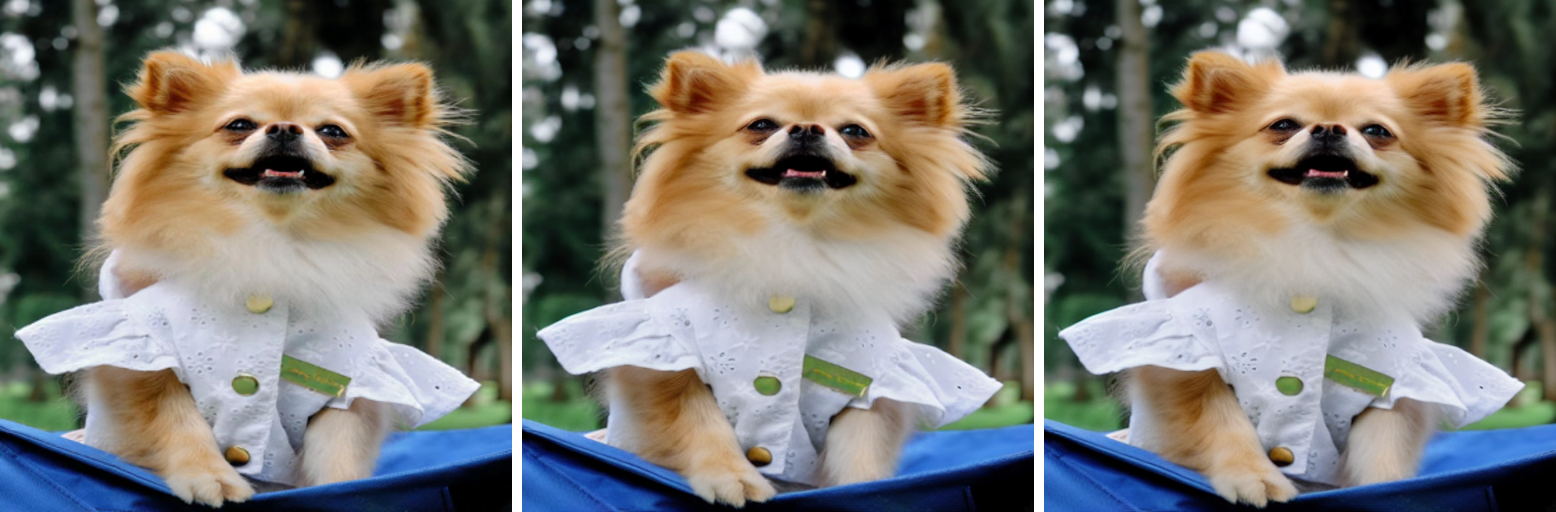

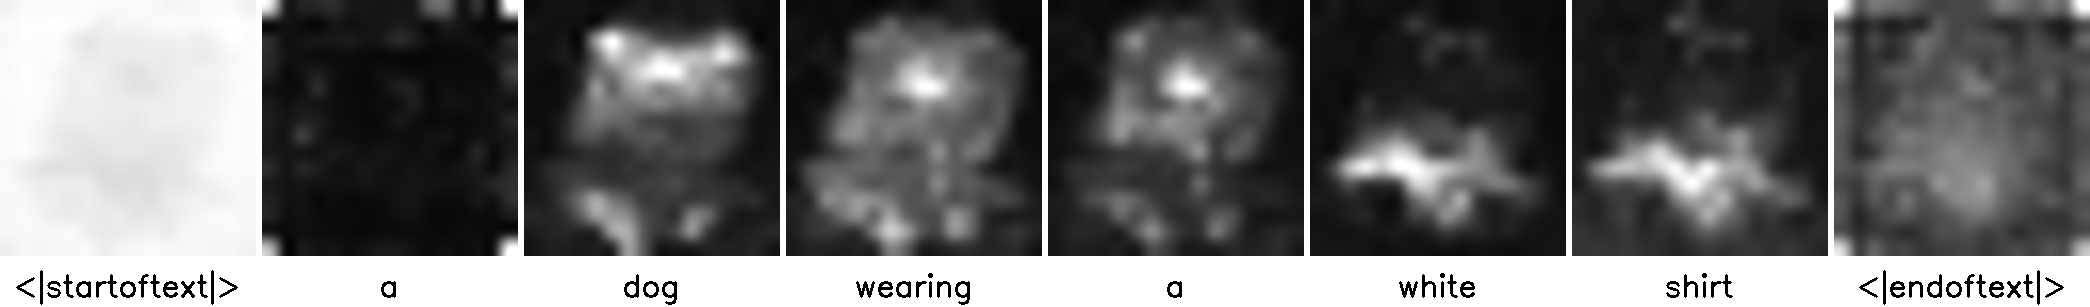

In [23]:
prompts = [prompt]
controller = AttentionStore()
image_inv, x_t = run_and_display(
    prompts,
    controller,
    guidance_scale=1.0,  # set 1 for reconstruction, >1 for editing, default is GUIDANCE_SCALE.
    ori_latent_list=ori_latent_list,
    aux_latent=aux_latent_list[-1],
    run_baseline=False,
    verbose=False,
)
print(
    "showing from left to right: the ground truth image, the vq-autoencoder reconstruction, the inverted image"
)
ptp_utils.view_images([image_gt, image_enc, image_inv[0]])
show_cross_attention(controller, 16, ["up", "down"])

  0%|          | 0/50 [00:00<?, ?it/s]

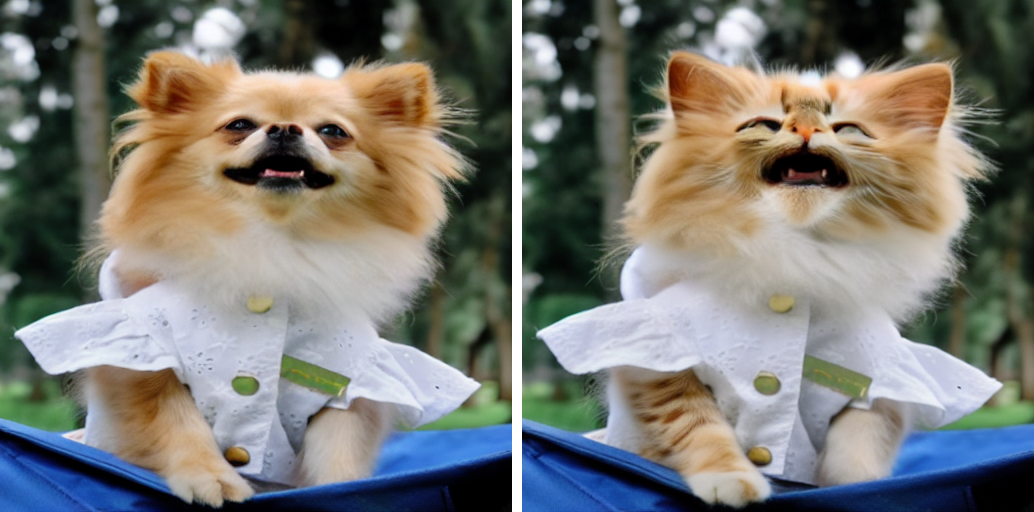

In [24]:
prompts = ["A dog wearing a white shirt", "A cat wearing a white shirt"]

cross_replace_steps = {
    "default_": 0.1,
}
self_replace_steps = 0.8
blend_word = (
    ("dog",),
    ("cat",),
)  # for local edit. If it is not local yet - use only the source object: blend_word = ((('cat',), ("cat",))).
eq_params = {
    "words": ("cat",),
    "values": (2,),
}  # amplify attention to the word "tiger" by *2

controller = make_controller(
    prompts, True, cross_replace_steps, self_replace_steps, blend_word, eq_params
)
images, x_t = run_and_display(
    prompts,
    controller,
    ori_latent_list=ori_latent_list,
    aux_latent=aux_latent_list[-1],
    run_baseline=False,
    verbose=False,
)
ptp_utils.view_images([image_enc, images[1]])
# ptp_utils.view_images([image_gt, images[0]])
# show_cross_attention(controller, 16, ["up", "down"])
# print("Image is highly affected by the self_replace_steps, usually 0.4 is a good default value, but you may want to try the range 0.3,0.4,0.5,0.7 ")

  0%|          | 0/50 [00:00<?, ?it/s]

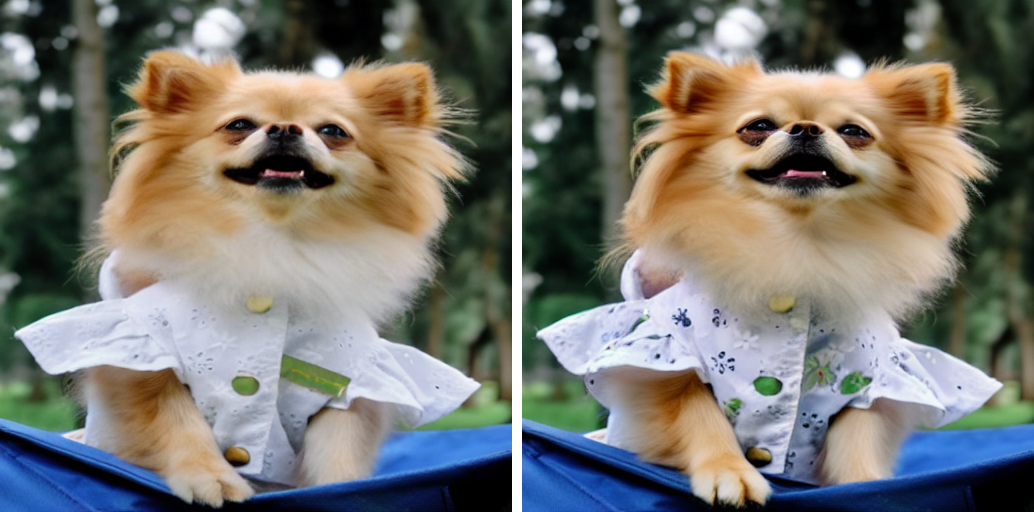

In [25]:
prompts = ["a dog wearing a white shirt", "a dog wearing a floral shirt"]

cross_replace_steps = {
    "default_": 0.5,
}
self_replace_steps = 0.1
blend_word = (
    ("white",),
    ("floral",),
)  # for local edit. If it is not local yet - use only the source object: blend_word = ((('cat',), ("cat",))).
eq_params = {
    "words": ("floral",),
    "values": (2,),
}  # amplify attention to the word "tiger" by *2

controller = make_controller(
    prompts, True, cross_replace_steps, self_replace_steps, blend_word, eq_params
)
images, x_t = run_and_display(
    prompts,
    controller,
    ori_latent_list=ori_latent_list,
    aux_latent=aux_latent_list[-1],
    run_baseline=False,
    verbose=False,
)
ptp_utils.view_images([image_enc, images[1]])

  0%|          | 0/50 [00:00<?, ?it/s]

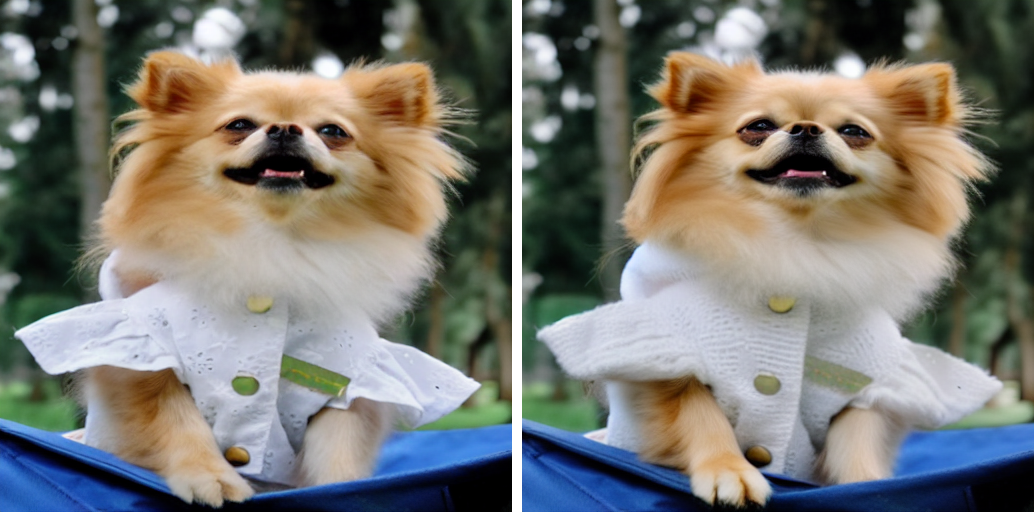

In [27]:
prompts = ["a dog wearing a white shirt", "a dog wearing a white sweater"]

cross_replace_steps = {
    "default_": 0.1,
}
self_replace_steps = 0.1
blend_word = (
    ("shirt",),
    ("sweater",),
)  # for local edit. If it is not local yet - use only the source object: blend_word = ((('cat',), ("cat",))).
eq_params = {
    "words": ("sweater",),
    "values": (2,),
}  # amplify attention to the word "tiger" by *2

controller = make_controller(
    prompts, True, cross_replace_steps, self_replace_steps, blend_word, eq_params
)
images, x_t = run_and_display(
    prompts,
    controller,
    ori_latent_list=ori_latent_list,
    aux_latent=aux_latent_list[-1],
    run_baseline=False,
    verbose=False,
)
ptp_utils.view_images([image_enc, images[1]])

  0%|          | 0/50 [00:00<?, ?it/s]

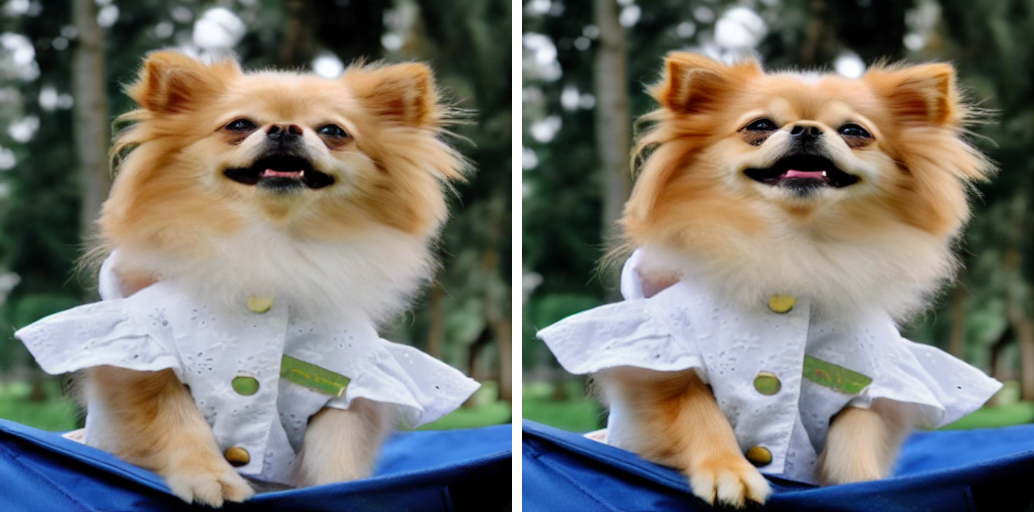

In [28]:
prompts = ["a dog wearing a white shirt", "a smiling dog wearing a shirt"]

cross_replace_steps = {
    "default_": 0.1,
}
self_replace_steps = 0.6
blend_word = (("dog",), ("dog",))  # for local edit
eq_params = {
    "words": ("smiling",),
    "values": (5,),
}  # amplify attention to the words "silver" and "sculpture" by *2

controller = make_controller(
    prompts, False, cross_replace_steps, self_replace_steps, blend_word, eq_params
)
# images, _ = run_and_display(prompts, controller, run_baseline=False, latent=x_t, uncond_embeddings=uncond_embeddings)
images, x_t = run_and_display(
    prompts,
    controller,
    ori_latent_list=ori_latent_list,
    aux_latent=aux_latent_list[-1],
    run_baseline=False,
    verbose=False,
)
ptp_utils.view_images([image_enc, images[1]])

  0%|          | 0/50 [00:00<?, ?it/s]

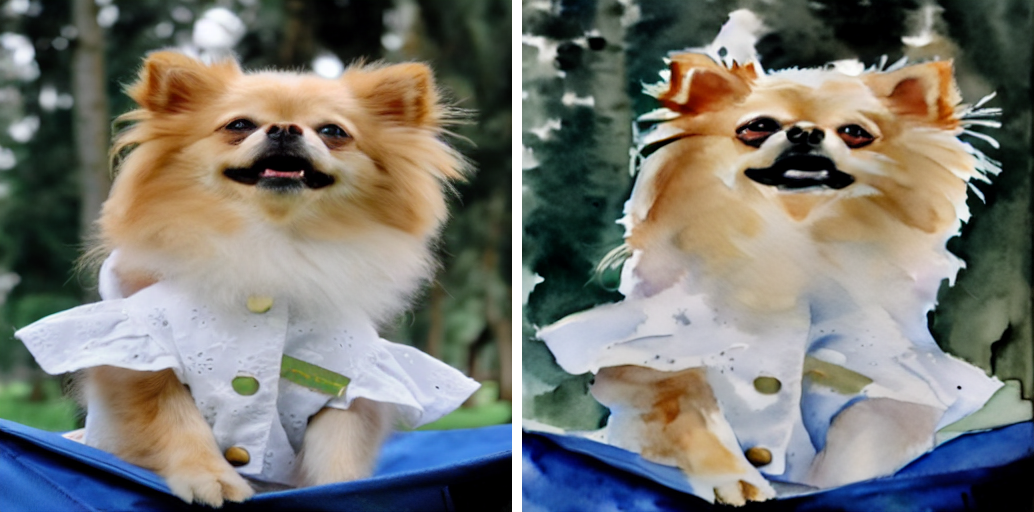

In [29]:
prompts = [
    "a dog wearing a white shirt",
    "watercolor drawing of a dog wearing a white shirt",
]

cross_replace_steps = {
    "default_": 0.7,
}
self_replace_steps = 0.2
blend_word = None
eq_params = {
    "words": (
        "watercolor",
        "drawing",
    ),
    "values": (
        5,
        2,
    ),
}  # amplify attention to the word "watercolor" by 5

controller = make_controller(
    prompts, False, cross_replace_steps, self_replace_steps, blend_word, eq_params
)
# images, _ = run_and_display(prompts, controller, run_baseline=False, latent=x_t, uncond_embeddings=uncond_embeddings)
images, x_t = run_and_display(
    prompts,
    controller,
    ori_latent_list=ori_latent_list,
    aux_latent=aux_latent_list[-1],
    run_baseline=False,
    verbose=False,
)
ptp_utils.view_images([image_enc, images[1]])